# Using wandb to track stats

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
model_path = "/gdrive/MyDrive/PPNCKH/saved/TREC/XLM-RoBERTa"

# Data downloader


In [3]:
!pip install tokenizers -q
!pip install transformers -q
!pip install datasets -q
!pip install evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 8.3 MB/s eta 0:00:00


In [4]:
# Random
from transformers import set_seed
set_seed(42)

In [5]:
from datasets import load_dataset
from datasets import DatasetDict

train_dataset = load_dataset("trec", split = "train")
test_dataset = load_dataset("trec", split = "test")

Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset trec downloaded and prepared to /root/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2. Subsequent calls will reuse this data.


Split the train into train and dev

In [6]:
train, dev = train_dataset.train_test_split(
    test_size = .2,
    seed = 42,
    stratify_by_column = "coarse_label"
).values()

In [7]:
train

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 4361
})

In [8]:
dev

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 1091
})

In [9]:
test_dataset

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 500
})

In [10]:
dataset = DatasetDict({
    "train" : train,
    "dev" : dev,
    "test" : test_dataset
})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 4361
    })
    dev: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 1091
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})

In [12]:
num_labels = len(dataset["train"].features["coarse_label"].names)

In [13]:
num_labels

6

# Preprocessing

In [14]:
from transformers import AutoTokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", use_fast = True)

In [16]:
tokenizer(dataset["train"][0]["text"])

{'input_ids': [0, 15757, 70, 53702, 450, 83, 65903, 48141, 390, 10, 48748, 70615, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation = True)

In [18]:
tokenized_dataset = dataset.map(preprocess_function, batched = True, remove_columns = ["fine_label"])

Map:   0%|          | 0/4361 [00:00<?, ? examples/s]

Map:   0%|          | 0/1091 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Rename the label column to fit the concept

In [19]:
tokenized_dataset = tokenized_dataset.rename_column("coarse_label", "labels")

In [20]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4361
    })
    dev: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1091
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

# Finetuning XLM-roberta for text classification

In [21]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy

In [22]:
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels = num_labels)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [23]:
batch_size = 16
learning_rate = 2e-5
weight_decay = .01
num_train_epochs = 10
eval_steps = 100
logging_steps = len(tokenized_dataset["train"]) // batch_size
early_stopping_patience = 3

In [24]:
args = TrainingArguments(
    "/saved",
    evaluation_strategy = IntervalStrategy.STEPS,
    # save_strategy = IntervalStrategy.STEPS,

    eval_steps = eval_steps,
    logging_steps = logging_steps,
    
    learning_rate = learning_rate,
    
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    
    num_train_epochs = num_train_epochs,
    
    weight_decay = weight_decay,
    save_total_limit = 3,
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
    # report_to = "wandb"
)

In [25]:
import evaluate
import numpy as np

In [26]:
metric = evaluate.load("accuracy")

In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis = 1)

    return metric.compute(predictions = predictions, references = labels)

In [28]:
trainer = Trainer(
    model,
    args,
    train_dataset = tokenized_dataset["train"],
    eval_dataset = tokenized_dataset["dev"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience = early_stopping_patience)]
)

## Training

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
100,No log,0.692439,0.796517
200,No log,0.371333,0.891842
300,0.857900,0.336016,0.910174
400,0.857900,0.340063,0.918423
500,0.857900,0.360065,0.918423
600,0.309400,0.274681,0.942255
700,0.309400,0.322143,0.932172
800,0.309400,0.262683,0.940422
900,0.189400,0.318415,0.944088
1000,0.189400,0.319596,0.942255


TrainOutput(global_step=2300, training_loss=0.2006507409137228, metrics={'train_runtime': 552.6676, 'train_samples_per_second': 78.908, 'train_steps_per_second': 4.94, 'total_flos': 487244186874612.0, 'train_loss': 0.2006507409137228, 'epoch': 8.42})

In [ ]:
trainer.save_model(model_path)

# Evaluation

In [30]:
import torch

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels = num_labels).to(device)

Count parameters

In [33]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [34]:
count_parameters(model)

+------------------------------------------------------------+------------+
|                          Modules                           | Parameters |
+------------------------------------------------------------+------------+
|         roberta.embeddings.word_embeddings.weight          | 192001536  |
|       roberta.embeddings.position_embeddings.weight        |   394752   |
|      roberta.embeddings.token_type_embeddings.weight       |    768     |
|            roberta.embeddings.LayerNorm.weight             |    768     |
|             roberta.embeddings.LayerNorm.bias              |    768     |
|    roberta.encoder.layer.0.attention.self.query.weight     |   589824   |
|     roberta.encoder.layer.0.attention.self.query.bias      |    768     |
|     roberta.encoder.layer.0.attention.self.key.weight      |   589824   |
|      roberta.encoder.layer.0.attention.self.key.bias       |    768     |
|    roberta.encoder.layer.0.attention.self.value.weight     |   589824   |
|     robert

278048262

In [ ]:
trainer.evaluate()

{'eval_loss': 0.29775798320770264,
 'eval_accuracy': 0.9560036663611365,
 'eval_runtime': 1.8653,
 'eval_samples_per_second': 584.897,
 'eval_steps_per_second': 36.992,
 'epoch': 8.42}

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])

predictions = np.argmax(predictions, axis = 1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.93      0.98      0.95        89
           2       0.99      0.94      0.97       145
           3       0.98      1.00      0.99        64
           4       0.98      0.98      0.98        81
           5       0.96      0.97      0.97       112

    accuracy                           0.97       500
   macro avg       0.97      0.98      0.98       500
weighted avg       0.97      0.97      0.97       500



In [ ]:
print(f"Accuracy = {accuracy_score(predictions, labels):.6f}, \
        Precision = {precision_score(predictions, labels, average = 'macro'):.6f}, \
        Recall = {recall_score(predictions, labels, average = 'macro'):.6f}, \
        F1 = {f1_score(predictions, labels, average = 'macro'):.6f}")

Accuracy = 0.970000,         Precision = 0.973802,         Recall = 0.978480,         F1 = 0.975911


In [ ]:
print(confusion_matrix(predictions, labels))

[[  9   0   0   0   0   0]
 [  0  87   0   1   1   0]
 [  0   3 137   0   1   4]
 [  0   0   0  64   0   0]
 [  0   2   0   0  79   0]
 [  0   2   1   0   0 109]]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

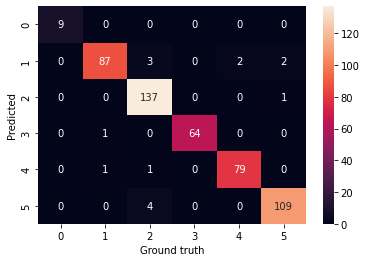

In [ ]:
sns.heatmap(confusion_matrix(labels, predictions), annot = True, fmt = "g")
plt.ylabel("Predicted")
plt.xlabel("Ground truth")
plt.show()

In [ ]:
for text, y_pred, y_truth in zip(tokenized_dataset["test"][0:10]["text"], predictions[0:10], labels[0:10]):
    print(f"{text} -- {y_pred} -- {y_truth}")

How far is it from Denver to Aspen ? -- 5 -- 5
What county is Modesto , California in ? -- 4 -- 4
Who was Galileo ? -- 3 -- 3
What is an atom ? -- 2 -- 2
When did Hawaii become a state ? -- 5 -- 5
How tall is the Sears Building ? -- 5 -- 5
George Bush purchased a small interest in which baseball team ? -- 3 -- 3
What is Australia 's national flower ? -- 1 -- 1
Why does the moon turn orange ? -- 2 -- 2
What is autism ? -- 2 -- 2


In [ ]:
for i in range(len(predictions)):
    if predictions[i] != labels[i]:
        print(tokenized_dataset["test"][i]["text"])
        print(f"Predicted: {predictions[i]} - Label: {labels[i]}")

What does cc in engines mean ?
Predicted: 5 - Label: 2
What is the speed hummingbirds fly ?
Predicted: 2 - Label: 5
What is the longest major league baseball-winning streak ?
Predicted: 5 - Label: 1
The sun 's core , what is the temperature ?
Predicted: 2 - Label: 5
What is the sales tax in Minnesota ?
Predicted: 2 - Label: 1
What is the melting point of copper ?
Predicted: 2 - Label: 5
What New York City structure is also known as the Twin Towers ?
Predicted: 1 - Label: 4
What is the electrical output in Madrid , Spain ?
Predicted: 5 - Label: 1
What is the criterion for being legally blind ?
Predicted: 2 - Label: 1
What are the twin cities ?
Predicted: 2 - Label: 4
What is foot and mouth disease ?
Predicted: 2 - Label: 1
What is the melting point of gold ?
Predicted: 2 - Label: 5
What is the only artery that carries blue blood from the heart to the lungs ?
Predicted: 4 - Label: 1
What monastery was raided by Vikings in the late eighth century ?
Predicted: 4 - Label: 1
What did Jesse J

Inference time measuring

In [ ]:
import torch

In [ ]:
def predict(text, model):
    tokenized = tokenizer(text, return_tensors = "pt").to(device)
    output = model(**tokenized)[0].detach().cpu().numpy()
 
    prediction = np.argmax(output, axis = 1)[0]

    return prediction

In [ ]:
predict("How far is it from Denver to Aspen ?", model = model)

5

In [ ]:
from time import perf_counter

In [ ]:
from tqdm import tqdm_notebook

In [ ]:
predicted_timelapse = []

for text in tqdm_notebook(tokenized_dataset["test"]["text"]):
    start_time = perf_counter()
    predict(text = text, model = model)
    end_time = perf_counter()

    predicted_timelapse.append(end_time - start_time)

<ipython-input-161-9fc675d8524a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for text in tqdm_notebook(tokenized_dataset["test"]["text"]):


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
timelapse_mean = np.mean(predicted_timelapse) * 1000
timelapse_std = np.std(predicted_timelapse) * 1000

In [ ]:
print(f"Mean: {timelapse_mean:.8f}, stdev: {timelapse_std:.8f} ms")

Mean: 16.93295264, stdev: 8.98739586 ms


In [ ]:
# wandb.finish()